This notebook solves a household problem with stochastic income fluctuation.
Model
--
The household chooses its consumption and savings while being constraint by its budget set. Savings pay a constant interest rate.

The sequence problem:
$$\underset{ \left(c_t, a_{t+1}\right)_{t=0}^\infty } {max} \sum_{t=0}^\infty \beta^t \, u( c_t )$$
s.t.
$$a_{t+1} = (1+r) a_t + y(s_t) - c_t \quad \forall t$$
$$a_t \geq \underline{a}\quad\forall t$$
$$a_0 \, \text{given}$$

can be written recursively as:

$$V(a, s) = \underset{ a' \geq \underline{a} } {max} \, u\big( (1+r) a + y(s) - a'  \big) + \beta \, \mathbb{E} \Big[ V \big(a', s' \big) \, \big| \,\theta \Big]$$
The solution of this Bellman equation is a policy function $a'(a, s)$ for consumption.

In [1]:
using Parameters
using BasisMatrices
using LaTeXStrings
using Plots; pyplot();
using QuantEcon

In [2]:
@with_kw immutable HHwIncomeFluct
    β::Float64                           # discount factor
    γ::Float64                           # RRA
    Π::Array{Float64,2}                  # transition probabilities
    Y::Vector{Float64}                   # income grid
    r::Float64                           # interest rate
end

household = HHwIncomeFluct(β = 0.95, γ = 2, Π = [0.95 0.05 0.0; 0.10 0.70 0.20; 0.0 0.25 0.75], 
    Y = [0.25, 0.75, 1.0], r = 0.02);

u_crra(c, γ) = c.^(1-γ) ./ (1-γ)
u_crra_prime(c, γ) = c.^-γ
u_crra_prime_inv(u, γ) = u.^(-1/γ)

u_crra_prime_inv (generic function with 1 method)

In [3]:
@unpack β, γ, Π, Y, r = household

basis = Basis(ChebParams(12, 0, 20), LinParams(Y, 0))
#basis = Basis(SplineParams(linspace(0.1,20,10), 0, 3), LinParams(Y, 0))

Ψ = BasisMatrix(basis, Expanded()).vals[1]
S, (A, Y) = nodes(basis);

In [4]:
V0 = vcat(3+log.(A+10), 3.1+log.(A+15), 3.2+log.(A+20))
c0 = Ψ \ V0;

Numerical Method: Envelope Condition
--

In [17]:
c = copy(c0)
V = copy(V0)

V_old = zeros(V0)
uprime = zeros(V0)
stop = false
iteration = 0

#plot(A, BasisMatrix(basis, Expanded(), hcat(collect(A), 0.75*ones(A))).vals[1] * c, label = iteration)
plot(A, reshape(V[1:12], 12,1), label = iteration)

while !stop
    
    V_old = copy(V)
    uprime = BasisMatrix(basis, Expanded(), S, [1 0]).vals[1] * c ./ (1+r)
#    uprime = ifelse.(uprime .> 0, uprime, vcat(uprime[1], uprime[1:35]))
    
    cons = u_crra_prime_inv(uprime, γ) 
    
    aprime = S[:,2] + (1+r) * S[:,1] - cons
    
    binding = aprime .< A[1]
    
    cons = ifelse.(binding, (1+r)*S[:,1] + S[:,2] - A[1], cons)
    aprime = ifelse.(binding, A[1], aprime)
    
    V = (u_crra(cons, γ) + β * sum(kron(Π, fill(1,12)) .* 
            hcat([(BasisMatrix(basis, Expanded(), hcat(aprime, fill(y,length(aprime)))).vals[1] * c) for y in Y]...),2))[:,1]
    
    c = Ψ \ V;
    
    if (maximum(abs.(V-V_old)) < 1e-10 || iteration == 2)
        stop = true
    end
    
    iteration += 1
    if (iteration % 1 == 0) 
        #plot!(A, BasisMatrix(basis, Expanded(), hcat(collect(A), 0.75*ones(A))).vals[1] * c, label = iteration)
        plot!(A, reshape(V[1:12], 12,1), label = iteration)
    end
end

#plot!(A, BasisMatrix(basis, Expanded(), hcat(collect(A), 0.75*ones(A))).vals[1] * c, label = iteration)
plot!(A, reshape(V[1:12], 12,1), label = iteration)

LoadError: DomainError:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.


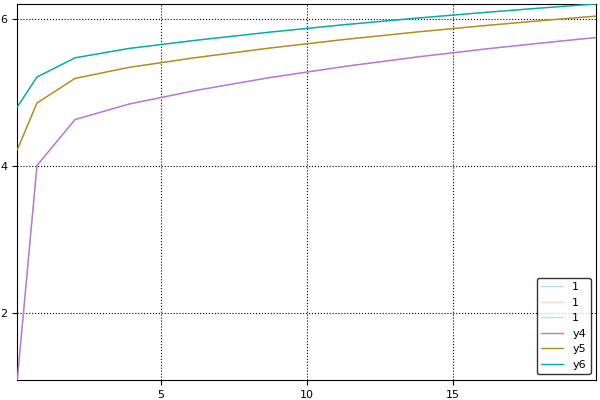

In [18]:
plot(A, reshape(V, 12,3), label = iteration, alpha = 0.3)
plot!(A, reshape(BasisMatrix(basis, Expanded(), S, [0 0]).vals[1] * c, 12,3))


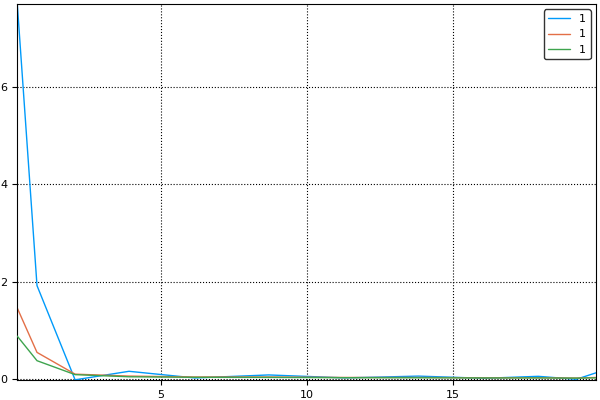

In [19]:
plot(A, reshape(BasisMatrix(basis, Expanded(), S, [1 0]).vals[1] * c, 12, 3), label = iteration)

Numerical Method: Collocation
--

In [8]:
using Parameters
using BasisMatrices
using LaTeXStrings
using Plots; pyplot();
using QuantEcon

In [ ]:
@with_kw mutable struct HHwIncomeFluct
    β::Float64                           # discount factor
    γ::Float64                           # RRA

    # income
    Y_chain::MarkovChain{Float64, Matrix{Float64}, Vector{Float64}} # Markov chain of income
    
    # assets
    r::Float64                           # interest rate
    A::Vector{Float64}
    
    basis::Basis                         # main Basis type
    bs::BasisMatrix                      # main basis matrix (Direct)
    Φ::SparseMatrixCSC                   # main basis matric (Expanded)
    Emat::SparseMatrixCSC                # transition matrix times basis matrix
    Φy::SparseMatrixCSC                  # income part of the basis matrix
end

household = HHwIncomeFluct(β = 0.95, γ = 2, Π = [0.95 0.05 0.0; 0.10 0.70 0.20; 0.0 0.25 0.75], 
    Y = [0.25, 0.75, 1.0], r = 0.02);

u_crra(c, γ) = c.^(1-γ) ./ (1-γ)
u_crra_prime(c, γ) = c.^-γ
u_crra_prime_inv(u, γ) = u.^(-1/γ)

In [5]:
Emat = kron(Π, speye(length(A)))*Ψ;

In [6]:
@unpack β, γ, Π, Y, r = household

basis = Basis(SplineParams(linspace(0.1,20,10), 0, 3), LinParams(Y, 0))

bs = BasisMatrix(basis, Direct())
Φ = convert(bs, Expanded())
S, (A, Y) = nodes(basis)
Emat = kron(Π, speye(Na))*Φ
Φy = bs.vals[2] 

c = copy(c0)
V = copy(V0)

cE = copy(c0)
VE = copy(V0)

V_old = zeros(V0)
stop = false
iteration = 0

function evaluate(aprime, h::HHwIncomeFluct) 
    
end

while !stop
    
    
    
    lower_bound = zeros(size(S, 1), )
    upper_bound = (1 + r).*S[:, 1] + S[:, 2]
    f(ap::Vector{Float64}) = value(h, s, ap; other_pols=false)
    ap, v1 = golden_method(f, lower_bound, upper_bound)
    v1, Φapy = value(h, s, ap; other_pols=true)

    # Compute expected value function
    v2 = h.Emat*h.c1
    
end

LoadError: [91mMethodError: First argument to `convert` must be a Type, got BasisMatrix{BasisMatrices.Direct} of order [0 0][39m

In [7]:
?golden_method

search: golden_method



No documentation found.

`QuantEcon.golden_method` is a `Function`.

```
# 2 methods for generic function "golden_method":
golden_method(f::Function, a::AbstractArray{T,1} where T, b::AbstractArray{T,1} where T; tol, maxit) in QuantEcon at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Max\AppData\Local\JuliaPro-0.6.0.1\pkgs-0.6.0.1\v0.6\QuantEcon\src\optimization.jl:3
golden_method(f::Function, a::Real, b::Real; tol, maxit) in QuantEcon at C:\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\Users\Max\AppData\Local\JuliaPro-0.6.0.1\pkgs-0.6.0.1\v0.6\QuantEcon\src\optimization.jl:48
```
